In [11]:
import rioxarray as rxr
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
# import the mapping method

In [8]:
# import basin boundaries
hcdn_basins = gpd.read_file('../data/geodata/basin_station_sntl.json')
# create a filter to select only the basin of interest
basin_filter = hcdn_basins['gage'].isin(['09124500','09112500','09035900'])
# apply the filter
example_basins = hcdn_basins[basin_filter]
# check the crs 
print(example_basins.crs)
# write the crs to 32613
example_basins = example_basins.set_crs(32613, allow_override=True)
# check the crs again
print(example_basins.crs)


epsg:4326
EPSG:32613


In [5]:
# Now lets open the mean imagery for snowmelt 

# open the mean snowmelt image
mean_snowmelt = rxr.open_rasterio('../data/snowdata/Snowmelt_Timing_North_America_Mean_2001_2018_V2.tif', masked=True).squeeze()
# reproject the image to the basin crs
mean_snowmelt = mean_snowmelt.rio.reproject(example_basins.crs)


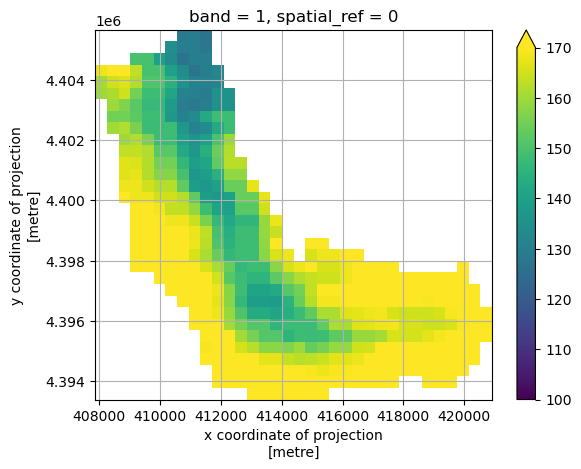

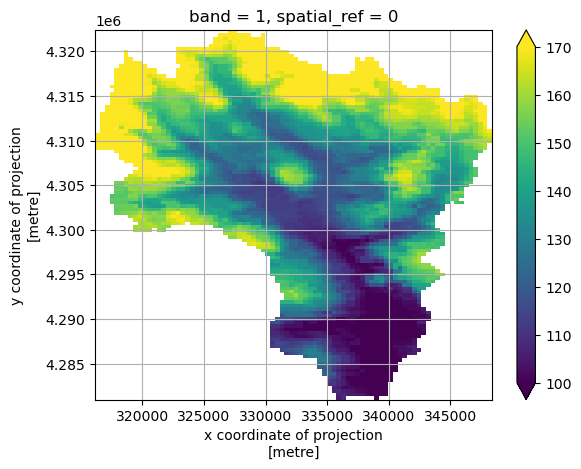

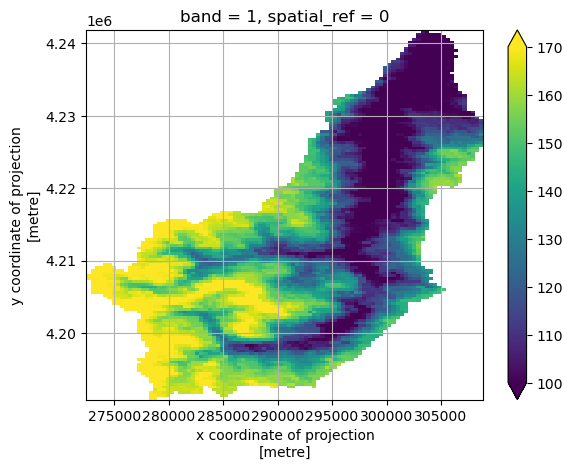

In [12]:
# create and empty dataframe with mean, median, and std columns 
basin_stats = pd.DataFrame(columns=['mean','median','std'], index=example_basins['gage'])
# clip the image to the first basin in example_basins
for site in example_basins['gage']:
    mean_snowmelt_clip = mean_snowmelt.rio.clip(example_basins[example_basins['gage']==site].geometry, example_basins.crs, drop=True)
    # filter values below 100
    # mean_snowmelt_clip = mean_snowmelt_clip.where(mean_snowmelt_clip>90)
    # add values to basin_stats
    basin_stats.loc[site] = [mean_snowmelt_clip.mean().values, mean_snowmelt_clip.median().values, mean_snowmelt_clip.std().values]
    fig, ax = plt.subplots()
    mean_snowmelt_clip.plot(ax=ax,vmin=100, vmax=170)
    ax.grid()

In [75]:
# save basin_stats
basin_stats.to_csv('../data/snowdata/example_basin_snow_stats.csv')

In [76]:
basin_stats

,mean,median,std
gage,,,
09035900,160.90076,165.0,13.863846778869629
09112500,139.77406,140.11111450195312,25.298030853271484
09124500,133.84749,136.55555725097656,26.73946189880371


### Comparing to SNTL site values

In [31]:
import xarray as xr
import numpy as np

In [67]:
# open ucrb_hcdn_sntl_all_20220930.nc
ds = xr.open_dataset('../data/snowdata/ucrb_hcdn_sntl_all_20220930.nc')
example_sntl = ds.sel(Location=' 380:CO:SNTL')['WTEQ']
melt_timing = np.zeros(len(example_sntl.Date.dt.year.to_pandas().unique()))
for i,year in enumerate(example_sntl.Date.dt.year.to_pandas().unique()):
    tmp = example_sntl.where(example_sntl.Date.dt.year==year, drop=True)
    # calculate the 7 day rolling mean of wteq
    tmp_7day = tmp.rolling(Date=7, center=True).mean()
    # make values less than 0 equal to 0 but keep nans
    tmp_7day = tmp_7day.where((tmp_7day>0) | (tmp_7day.isnull()), 0)
    # drop values greater than 220
    # tmp_7day = tmp_7day.where(tmp_7day<220, 0)

    # print the day of year of the first zero value
    if tmp_7day.idxmin(dim='Date').dt.dayofyear.values > 210:
        melt_timing[i] = np.nan
    else:
        melt_timing[i] = (tmp_7day.idxmin(dim='Date').dt.dayofyear.values)




In [73]:

np.nanmean(melt_timing)

150.2439024390244